# Project 1 - Airline AI Assistant

For this first project, we'll work on one of the very common use cases for Gen AI: a chatbot

## Setting up your keys

If you haven't done so already, you'll need to create API keys from OpenAI.

For OpenAI, visit https://openai.com/api/  

When you get your API keys, you need to set them as environment variables.

EITHER (recommended) create a file called .env in this project root directory, and set your keys there:
```
OPENAI_API_KEY=xxxx
````

OR enter the keys directly in the cells below.

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
from IPython.display import Markdown, display
import gradio as gr

In [2]:
# Load environment variables in a file called .env

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
# Used for printing in color

BLUE = "\033[34m"
RESET = "\033[0m"

OpenAI API Key exists and begins sk-proj-


In [3]:
# For our chatbot we will select GPT-4o-mini due to the price efficiency

MODEL = "gpt-4o-mini"
openai = OpenAI()

## Our first Assistant conversation

We can call the API with a conversation - a list of dictionaries representing each interaction:

```
[
    {"role": "system", "content": "essential instructions here, including tone"},
    {"role": "user", "content": "a question from the user"},
    {"role": "assistant": "content": "a response"},
    ...
]
```

In [8]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [9]:
conversation = [{"role": "system", "content": system_message}]
done = False

while not done:
    message = input("Your message:")
    if message == "stop":
        print(BLUE + "Bye" + RESET)
        done = True
    else:
        conversation.append({"role": "user", "content": message})
        response = openai.chat.completions.create(model=MODEL, messages=conversation)
        reply = response.choices[0].message.content
        conversation.append({"role": "assistant", "content": reply})
        print(BLUE + reply + RESET)

Your message: stop


Bye


## Amazing! As simple as that.

### Isn't it great to see the way the LLM keeps the context of the conversation?

### It's important to realize that this is an illusion - we pass in the entire conversation with every call.

Try playing with the System Prompt to vary the tone.  

And now we wrap this in a simple chat() function,  
and then we use the shockingly simple Gradio platform to bring up a Chatbot UI.

First, the chat function, which takes the current message and the history of prior messages:

In [10]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

In [11]:
# And look how complicated it is to launch a User Interface, with the fabulous gradio platform

gr.ChatInterface(fn=chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Tools

Another incredibly powerful feature is the ability to give the LLM some "tools"  
Or functions it can call in order to do its job better

In [12]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [14]:
get_ticket_price("London")

Tool get_ticket_price called for Paris


'$899'

In [15]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False,
    }
}

In [16]:
tools = [{"type": "function", "function": price_function}]

In [17]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [18]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [19]:
gr.ChatInterface(fn=chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London


## Agentization (in a simple way)

Giving our Assistant the ability to interact with a Tool could be considered adding an Agentic design pattern to our solution. LLMs being able to use tools is one of the Hallmarks of Agentic AI.

Another example is having multiple AIs collaborate to solve the problem. Let's add another AI to the mix!

Let's pick a fun one: adding multi-modality..

In [21]:
import base64
from io import BytesIO
from PIL import Image

def artist_agent(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

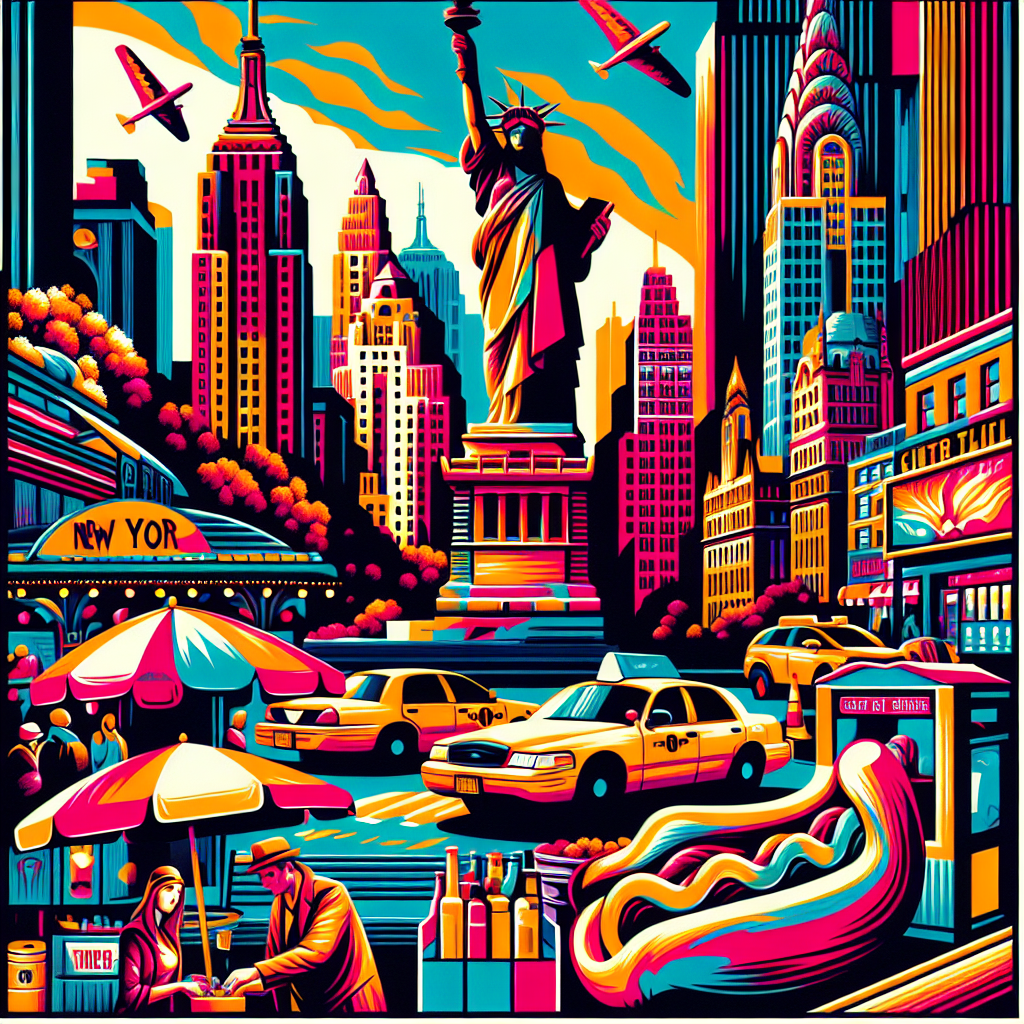

In [22]:
image = artist_agent("New York")
display(image)

## Bringing it all together in a mini Agent Framework

Finally we bring together our Assistant, Tool and Agent


In [23]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist_agent(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]
    return history, image

In [25]:
# More involved Gradio code as we're not using the preset Chat interface!

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London


## Congratulations!

You just created a multi-modal AI Assistant with tools and agents

Further exercises:

1. Swap OpenAI for Claude to experience the changes in style
2. Add another agent to the mix: have the chat respond in audio as well as text
3. Add another tool to simulate booking the flight